# Training Hydrophobicity Graph Classifier

## Preliminaries:

In [2]:
import os
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.size'] = 18
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.variant'] = 'normal'

# Colab - Pytorch Geometric installation according to Pytorch documentation

#os.environ['TORCH'] = torch.__version__
#print(torch.__version__)
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool

from IPython.display import Javascript

In [4]:
# Local machine
%cd C:\Users\yuval\Projects\HydrophobicityGraphClassifier

# Colab

#from google.colab import drive
#drive.mount('/content/drive')
#%cd drive/MyDrive/HydrophobicityGraphClassifier/


C:\Users\yuval\Projects\HydrophobicityGraphClassifier


## Preparing the dataset:

### Defining custom Dataset:

In [3]:
class MyDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return os.listdir(self.raw_dir)

    @property
    def processed_file_names(self):
        data_file_names = [os.path.splitext(file_name)[0]+ '.pt' for file_name in self.raw_file_names]
        return data_file_names + ['pre_filter.pt', 'pre_transform.pt']

    @property
    def num_classes(self):
      return 2

    def process(self):
        idx = 0
        for raw_path in self.raw_paths:

            # Load the two arrays and scaler from the saved file using read_pickle()
            with open(raw_path, 'rb') as f:
                x, edge_index, y = pd.read_pickle(f)

            data_i = Data(x=torch.tensor(x, dtype=torch.float), 
                          edge_index=torch.tensor(edge_index, dtype=torch.long),
                          y=torch.tensor([int(y)], dtype=torch.long)) # You want the y as 1D int and not a scaler

            if self.pre_filter is not None and not self.pre_filter(data_i):
                continue

            if self.pre_transform is not None:
                data_i = self.pre_transform(data_i)

            torch.save(data_i, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names) - 2 # minus the pre_filter and pre_transform

    def get(self, idx):
        data_i = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data_i

In [4]:
dataset = MyDataset('Zinc_200D/GraphData')

### Examination:

In [ ]:
data = dataset.get(10)
data

Data(x=[19, 11], edge_index=[2, 40], y=[1])

In [ ]:
data.x

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.,

In [ ]:
data.edge_index

tensor([[ 0,  1,  1,  1,  2,  3,  3,  4,  4,  5,  5,  5,  6,  6,  6,  7,  7,  8,
          8,  9,  9,  9, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15, 16, 16,
         17, 17, 18, 18],
        [ 1,  0,  2,  3,  1,  1,  4,  3,  5,  4,  6, 13,  5,  7, 12,  6,  8,  7,
          9,  8, 10, 11,  9,  9, 12,  6, 11,  5, 14, 18, 13, 15, 14, 16, 15, 17,
         16, 18, 13, 17]])

In [ ]:
data.y

tensor([0])

In [5]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

According to this you can see that the bottleneck in your training is the sampling operation with the dataloader.

In [12]:
for data in loader:
  print('Finished sampling start moving')
  data = data.to(device)
  print(data)

Finished sampling start moving
DataBatch(x=[676, 11], edge_index=[2, 1438], y=[32], batch=[676], ptr=[33])
Finished sampling start moving
DataBatch(x=[629, 11], edge_index=[2, 1350], y=[32], batch=[629], ptr=[33])
Finished sampling start moving
DataBatch(x=[528, 11], edge_index=[2, 1108], y=[32], batch=[528], ptr=[33])
Finished sampling start moving
DataBatch(x=[675, 11], edge_index=[2, 1438], y=[32], batch=[675], ptr=[33])
Finished sampling start moving
DataBatch(x=[538, 11], edge_index=[2, 1130], y=[32], batch=[538], ptr=[33])
Finished sampling start moving
DataBatch(x=[555, 11], edge_index=[2, 1148], y=[32], batch=[555], ptr=[33])
Finished sampling start moving
DataBatch(x=[585, 11], edge_index=[2, 1216], y=[32], batch=[585], ptr=[33])
Finished sampling start moving
DataBatch(x=[545, 11], edge_index=[2, 1140], y=[32], batch=[545], ptr=[33])
Finished sampling start moving
DataBatch(x=[575, 11], edge_index=[2, 1210], y=[32], batch=[575], ptr=[33])
Finished sampling start moving
DataBa

KeyboardInterrupt: ignored

In [10]:
data = data.to(device)

In [ ]:
type(data)

torch_geometric.data.batch.DataBatch

In [ ]:
for data in loader:
    print(len(data))

32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
24


To split the data into training, validation and test sets, we use the `index_select` method which creates a subset of the dataset from specified indices idx.

In [ ]:
N = dataset.len()
idx = torch.randperm(N) # Random permutation of integers from 0 to N - 1
idx_train, idx_val, idx_test = idx[:int(0.8 * N)], idx[int(0.8 * N): int(0.9 * N)], idx[int(0.9 * N):]

train_dataset = dataset.index_select(idx_train)
val_dataset = dataset.index_select(idx_val)
test_dataset = dataset.index_select(idx_test)

In [ ]:
dataset.len()

Now we define the `Dataloader`.
Note for thet `shuffle` parameter, if set to True, the data will be reshuffled at every epoch.
We do not want such thing for the validation and test sets.

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

## Training:

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_p):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.dropout_p = dropout_p
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.lin(x)
        
        return x

In [6]:
def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

def print_status_bar(iteration, total, metrics):
    end = "" if iteration < total else "\n"
    metric_str = " - ".join(["{}: {:.4f}".format(m, metrics[m]) for m in metrics])
    print("\r{} - {}".format(progress_bar(iteration, total), metric_str), end=end)

def train(model, criterion, optimizer, loader, device, frac_batches=1):
    
    model.train()
    total_batch_num = int(len(loader) * frac_batches) # total number of batches used in the evaluation
    
    # running metrics
    weighted_loss_sum = 0
    total_instances_num = 0

    # Iterate in batches over the training dataset. data is a DataBatch object
    for current_batch_i, data in enumerate(loader):  
        if current_batch_i + 1 > total_batch_num:
           break

        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        
        # printing progress
        weighted_loss_sum += len(data) * loss
        total_instances_num += len(data)
        metrics = {'loss': weighted_loss_sum / total_instances_num} # weighted mean with respect to batches
        print_status_bar(current_batch_i + 1, total_batch_num, metrics)
         

@torch.no_grad()
def eval(model, criterion, loader, device):
    model.eval()

    # running metrics
    weighted_loss_sum = 0
    total_instances_num = 0
    correct_sum = 0

    # Iterate in batches over the training/test dataset. Each data is 
    for data in loader:  

        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
         
        # Compute the loss sum
        weighted_loss_sum += len(data) * criterion(out, data.y)  
        
        # Compute accuracy
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct_sum += int((pred == data.y).sum())  # summing the number of correct instances predictions
        total_instances_num += len(data)

    acc = correct_sum / total_instances_num  # number of correct instances predictions devided by the number of instances
    loss_mean = weighted_loss_sum / total_instances_num # weighted mean with respect to batches
    return acc, loss_mean

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

lr = 0.008
batch_size = 64
hidden_channels=64
dropout_p = 0.15

N = dataset.len()
idx = torch.randperm(N) # Random permutation of integers from 0 to N - 1
idx_train, idx_val, idx_test = idx[:int(0.8 * N)], idx[int(0.8 * N): int(0.9 * N)], idx[int(0.9 * N):]

model = GCN(hidden_channels=hidden_channels, dropout_p=dropout_p).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

train_dataset = dataset.index_select(idx_train)
val_dataset = dataset.index_select(idx_val)
test_dataset = dataset.index_select(idx_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

cuda


In [24]:
training_metrics = {'train_acc':[], 
                    'train_loss':[],
                    'val_acc':[],
                    'val_loss':[]}

best_val_loss = np.inf

for epoch in range(1, 25):
    print(f'Epoch: {epoch}')
    # Training
    train(model, criterion, optimizer, train_loader, device)

    # Evaluating
    train_acc, train_loss = eval(model, criterion, train_loader, device)
    val_acc, val_loss = eval(model, criterion, val_loader, device)

    # Retrieving from GPU to CPU numpy array and save results
    train_loss, val_loss = train_loss.cpu().numpy(), val_loss.cpu().numpy()
    for key, value in zip(['train_acc', 'train_loss', 'val_acc','val_loss'],
                          [train_acc, train_loss, val_acc, val_loss]):
        training_metrics[key].append(value)
    
    print(f'Train Acc: {train_acc:.4f}, Train loss: {train_loss:.4f}\n Val Acc: {val_acc:.4f}, Val loss: {val_loss:.4f}')

    # Saving best model
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model, 'Tutorials/model.pth')
      print('Saved model')

Epoch: 1
37/37 [==============================] - loss: 0.4649
Train Acc: 0.8484, Train loss: 0.3492
 Val Acc: 0.8571, Val loss: 0.3244
Saved model
Epoch: 2
37/37 [==============================] - loss: 0.3347
Train Acc: 0.8437, Train loss: 0.3227
 Val Acc: 0.8639, Val loss: 0.2844
Saved model
Epoch: 3
37/37 [==============================] - loss: 0.3179
Train Acc: 0.8671, Train loss: 0.2974
 Val Acc: 0.8878, Val loss: 0.2696
Saved model
Epoch: 4
37/37 [==============================] - loss: 0.3017
Train Acc: 0.8684, Train loss: 0.2820
 Val Acc: 0.8707, Val loss: 0.2650
Saved model
Epoch: 5
37/37 [==============================] - loss: 0.2939
Train Acc: 0.8782, Train loss: 0.2792
 Val Acc: 0.8878, Val loss: 0.2659
Epoch: 6
37/37 [==============================] - loss: 0.2930
Train Acc: 0.8825, Train loss: 0.2893
 Val Acc: 0.8980, Val loss: 0.2630
Saved model
Epoch: 7
37/37 [==============================] - loss: 0.3023
Train Acc: 0.8837, Train loss: 0.2844
 Val Acc: 0.8980, Val l

In [33]:
training_metrics = pd.DataFrame(training_metrics)
training_metrics.to_csv('Code/training_metrics.csv')

## Test set and plotting:

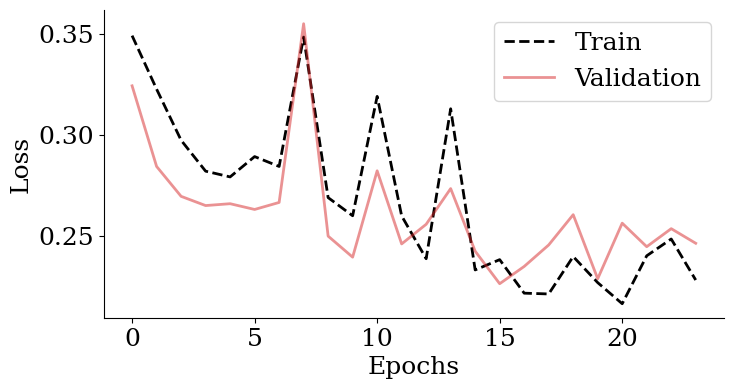

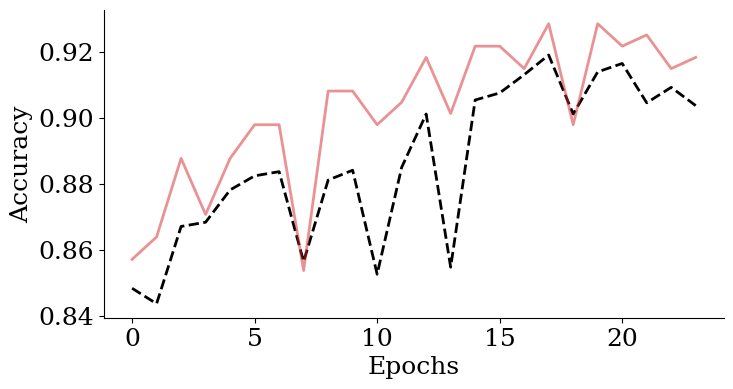

In [16]:
training_metrics = pd.read_csv('Code/training_metrics.csv')

def plot(metrics, ylabel, islegend):
    fig, axis = plt.subplots(1, 1, figsize=(8, 4))
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.set_xlabel('Epochs')
    axis.plot(metrics[0], label='Train', color='k', lw=2, ls='--')
    axis.plot(metrics[1], label='Validation', color='tab:red', lw=2, alpha=0.5)
    axis.set_ylabel(ylabel)
    if islegend:
        axis.legend()

metrics = [training_metrics['train_loss'], training_metrics['val_loss']]
ylabel = 'Loss'
islegend = True
plot(metrics, ylabel, islegend)
plt.savefig('Code/HydroClassifierTraining(a).pdf', bbox_inches='tight')

metrics = [training_metrics['train_acc'], training_metrics['val_acc']]
ylabel = 'Accuracy'
islegend = False
plot(metrics, ylabel, islegend)
plt.savefig('Code/HydroClassifierTraining(b).pdf', bbox_inches='tight')

In [32]:
model = torch.load('Tutorials/model.pth')

In [35]:
correct_sum = 0
total_instances_num = 0
model.eval()

with torch.no_grad():
  for data in test_loader:  
    data = data.to(device)
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1) 
    correct_sum += int((pred == data.y).sum()) 
    total_instances_num += len(data)

In [38]:
print('correct_sum:', correct_sum)
print('total_instances_num:', total_instances_num)
print('Test accuracy:', correct_sum / total_instances_num)

correct_sum: 274
total_instances_num: 294
Test accuracy: 0.9319727891156463
